In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [46]:
# Load the dataset
text = open('train.txt', 'r').read()[:1000000]
texttoint = {ch:i for i,ch in enumerate(sorted(set(text)))}
inttotext = {i:ch for i,ch in enumerate(sorted(set(text)))}
tokens = [texttoint[ch] for ch in text]

seq_len = 20
data = torch.tensor([tokens[i:i+seq_len+1] for i in range(len(tokens)-seq_len)])

data.shape

torch.Size([999980, 21])

In [47]:
len(texttoint)

110

In [51]:
# split train test validation

train_data = data[:int(0.9*len(data))]
val_data = data[int(0.9*len(data)):int(0.95*len(data))]
test_data = data[int(0.95*len(data)):]

X = train_data[:,:-1].to(device)
y = train_data[:,-1].to(device)

X_val = val_data[:,:-1].to(device)
y_val = val_data[:,-1].to(device)

X_test = test_data[:,:-1].to(device)
y_test = test_data[:,-1].to(device)


In [75]:
# define transformer model  

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        embed_dim = 16
        vocab_size = len(texttoint)
        self.kqv_dim = 16

        # input will be [B, T] - long 
        self.embed = nn.Embedding(vocab_size, embed_dim) # [B, T, D] - float
        self.pos_embed = nn.Embedding(seq_len, embed_dim)

        self.values = nn.Linear(embed_dim, self.kqv_dim)
        self.keys = nn.Linear(embed_dim, self.kqv_dim)
        self.queries = nn.Linear(embed_dim, self.kqv_dim)

        self.fc1 = nn.Linear(seq_len*self.kqv_dim, 200)
        self.layernorm1 = nn.LayerNorm(200)
        self.fc2 = nn.Linear(200, 200)
        self.layernorm2 = nn.LayerNorm(200)
        self.fc3 = nn.Linear(200, vocab_size)

    def forward(self, x):
        batch_size = x.shape[0]
        
        pos = self.pos_embed(torch.arange(seq_len).to(device))
        x = self.embed(x) + pos
        
        # K, Q, V
        values = self.values(x)
        keys = self.keys(x)
        queries = self.queries(x)
        
        # Attention
        attention = torch.matmul(queries, keys.transpose(-2,-1))
        attention = F.softmax(attention, dim=-1)
        attention = torch.matmul(attention, values)
        
        # Mask 
        attention = torch.tril(attention)
        attention[attention==0] = float('-inf')
        attention = attention.softmax(dim=-1)
        
        # Feed Forward
        x = self.fc1(attention.view(batch_size, seq_len*self.kqv_dim))
        x = self.layernorm1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = self.layernorm2(x)
        x = F.gelu(x)
        x = self.fc3(x)
        return x
    

Net = Model().to(device)
lossi = []


In [76]:
# train model

optimizer = torch.optim.Adam(Net.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

epochs = 1000
batch_size = 32

for epoch in range(epochs):
    indexes = torch.randint(len(X), (batch_size, ))

    batch_X = X[indexes]
    batch_y = y[indexes]
    #outputs = Net(F.one_hot(batch_X))
    outputs = Net(batch_X)
    loss = criterion(outputs, batch_y)
    lossi.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f'Epoch {epoch+1}/{epochs} loss: {loss.item():.4f}')


Epoch 1/1000 loss: 4.7238
Epoch 2/1000 loss: 4.6843
Epoch 3/1000 loss: 4.5011
Epoch 4/1000 loss: 4.2533
Epoch 5/1000 loss: 4.3008
Epoch 6/1000 loss: 4.1969
Epoch 7/1000 loss: 4.0796
Epoch 8/1000 loss: 4.3827
Epoch 9/1000 loss: 4.0660
Epoch 10/1000 loss: 3.8590
Epoch 981/1000 loss: 2.9286
Epoch 982/1000 loss: 3.2625
Epoch 983/1000 loss: 2.9510
Epoch 984/1000 loss: 3.1307
Epoch 985/1000 loss: 2.7194
Epoch 986/1000 loss: 3.2270
Epoch 987/1000 loss: 2.7341
Epoch 988/1000 loss: 2.7602
Epoch 989/1000 loss: 2.3248
Epoch 990/1000 loss: 3.1527
Epoch 991/1000 loss: 2.7657
Epoch 992/1000 loss: 2.7118
Epoch 993/1000 loss: 2.9529
Epoch 994/1000 loss: 2.5668
Epoch 995/1000 loss: 2.9292
Epoch 996/1000 loss: 2.7997
Epoch 997/1000 loss: 3.1265
Epoch 998/1000 loss: 2.3324
Epoch 999/1000 loss: 2.7861
Epoch 1000/1000 loss: 2.8639


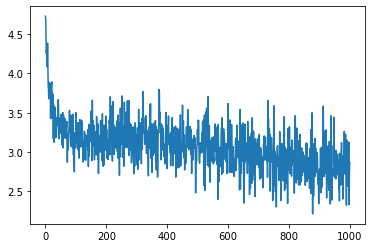

In [77]:
import matplotlib.pyplot as plt

plt.plot(lossi)

In [68]:
# validate on test set

In [15]:
torch.randint(100, (200,))



tensor([51, 91, 16, 63, 61, 14, 62, 74, 19, 71, 28, 16, 21, 97, 12, 33,  2, 44,
        60, 15, 47, 33, 77, 76, 52,  4, 39, 57, 27, 24, 92, 27, 18, 75,  1, 36,
        80, 66, 95, 27, 64, 77,  0, 94, 53, 94, 74, 44, 20, 60, 78, 97, 10, 81,
        29, 21, 98, 14, 18, 25, 15, 57,  9, 41, 36, 57, 37, 97, 68, 89, 66, 87,
        56, 15, 49, 27, 33, 57, 34, 40, 13, 92, 55, 32, 83, 35, 18, 69, 46, 11,
        16, 15, 70, 11,  0, 64, 81, 20, 67, 43, 17, 35, 13, 71, 41, 59,  6, 57,
        43,  9, 59,  4, 41, 91, 14, 66, 51, 59, 74, 14,  8, 95, 84, 69, 37, 32,
        91, 58, 62, 19, 49, 14, 50, 32, 69, 41,  8, 97, 70, 48, 12, 32, 85, 84,
        69, 41, 46, 27,  7, 32, 82, 18, 95,  2, 52, 83, 41, 90, 62, 43, 72, 45,
        99, 33,  2,  0, 97, 53, 18, 75, 54,  2, 51,  0, 17, 78, 32, 23, 46, 39,
        78,  9, 25, 48, 27, 70, 51, 81, 46, 24, 80, 82, 65, 89,  8, 50,  6, 54,
        70, 50])